**E-HEALTH - LABORATORY 4**

**DOWNLOAD THE DATASET**

In this laboratory, we will use the data that are available at link https://drive.google.com/file/d/1Bo5rCQYoeoCzKrMi8rMpVsjqfyuqDMVH/view?usp=sharing

We download the folder and add the data to the COLAB Notebook.

In [ ]:
%pip install googledrivedownloader
from googledrivedownloader import download_file_from_google_drive
import zipfile

download_file_from_google_drive(file_id='1Bo5rCQYoeoCzKrMi8rMpVsjqfyuqDMVH',
                                dest_path='./ehealth_lab_3.zip',
                                unzip=False,
                                overwrite=True)

with zipfile.ZipFile("./ehealth_lab_3.zip","r") as zip_ref:
    zip_ref.extractall("./ehealth_lab_3")

path_to_dataset_folder = "./ehealth_lab_3/"

We install and import `mne` and other useful Python packages.

In [ ]:
%pip install mne
import mne
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.9 MB/s eta 0:00:00


We define a method to plot a group of channels.

In [ ]:
def plot_signal_channels(times: np.ndarray,
                         signal_channels: np.ndarray,
                         channel_names: list,
                         amplitude: float = 1.0,
                         title: str = None):

    _, axes  = plt.subplots()

    ax = axes
    ax.set_facecolor('lightyellow')
    sub_ax = None

    channel_num = len(channel_names)

    shift = 2 * amplitude

    for index in range(channel_num):

        ax.plot(times, signal_channels[index] - (index + 1) * shift, color='k', linewidth=0.25)

    ax.set_yticks([- i * shift for i in range(1, channel_num + 1)], channel_names)

    ax.grid('on', which='both')
    ax.set_ylabel('Channel')
    ax.set_xlim([times[0], times[-1]])

    ax.set_ylim([-(channel_num + 1) * shift, shift])

    if title is not None:
        plt.title(title)

    ax.set_xlabel('Time [s]')


Today, we will work with a dataset of EEG signals from PhysioNet, a free-available repository of medical data, managed by MIT.

The full dataset can be found at https://physionet.org/content/eegmmidb/1.0.0/.

We consider a subset of the original data, organized in subfolders.

In [ ]:
os.listdir(path_to_dataset_folder)

['S010',
 'S005',
 'S008',
 'S006',
 'S001',
 'S009',
 'S002',
 'S007',
 'S004',
 'S003']

Each subfolder is associated with a patient. We focus on patient S001.

In [ ]:
patient_name = 'S001'

path_to_patient_folder = path_to_dataset_folder + patient_name + '/' # The folder of the patient that we want to study

os.listdir(path_to_patient_folder)

['S001R06.edf.event',
 'S001R06.edf',
 'S001R01.edf',
 'S001R02.edf.event',
 'S001R05.edf',
 'S001R03.edf.event',
 'S001R01.edf.event',
 'S001R04.edf.event',
 'S001R02.edf',
 'S001R03.edf',
 'S001R04.edf',
 'S001R05.edf.event']

We load one of the EEGs of the patient.

In [ ]:
file_name = 'S001R01.edf' # The file that we want to study
raw_data = mne.io.read_raw_edf(path_to_patient_folder +  file_name)

Extracting EDF parameters from /content/ehealth_lab_3/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Medical information can be found in the `mne.io.Raw.annotations` attribute.

In [ ]:
for annotation in raw_data.annotations:
  print(annotation)

OrderedDict([('onset', np.float64(0.0)), ('duration', np.float64(60.2)), ('description', np.str_('T0')), ('orig_time', datetime.datetime(2009, 8, 12, 16, 15, tzinfo=datetime.timezone.utc))])


Signal information are contained into the `mne.io.Raw.info` attribute.

In [ ]:
raw_data.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

We save the sampling frequency, the sampling period, the number of channels, and the channel names into specific variables.

In [ ]:
sampling_frequency = raw_data.info['sfreq'] # Sampling frequency
sampling_period = 1 / raw_data.info['sfreq'] # Sampling period
channel_names = raw_data.info['ch_names'] # List of channel names
channel_size = raw_data.info['nchan'] # Number of channel

We save the signal values and the time references.

In [ ]:
signal_values = raw_data.get_data() * 1000  # Unit of measure in millivolt
signal_times = raw_data.times  # Unit of measure in seconds
sample_size = len(signal_times) # Number of samples

We consider ten channels and a limited number of samples.

In [ ]:
selected_channel_names = ['P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.']
selected_channel_indexes = [channel_names.index(channel) for channel in selected_channel_names]
selected_sample_number = 2**13

In [ ]:
observed_samples = np.arange(selected_sample_number)
observed_times = signal_times[:selected_sample_number]
observed_channels = signal_values[selected_channel_indexes, :selected_sample_number]

We plot the raw observations, i.e., the observed channels.

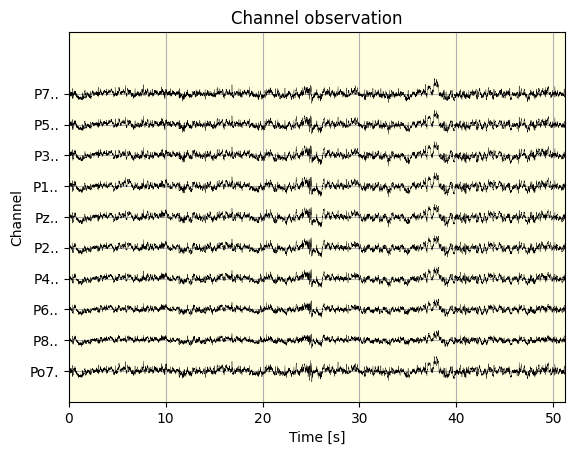

In [ ]:
plot_signal_channels(times=observed_times,
                     signal_channels=observed_channels,
                     channel_names=selected_channel_names,
                     amplitude=np.max(np.abs(observed_channels)),
                     title='Channel observation')

We assume that these **observed channels** were generated by a limited number of sources and set the goal of reconstructing the **source channels** following an approach based on independent component analysis (ICA).

**INDIPENDENT COMPONENT ANALYSIS (ICA) ON SYNTHETIC DATA**

Before applying the ICA algorithm on the EEG data, we consider an example, where six observed signals are generate from four sources defined as follows.

In [ ]:
source_signals = np.array([0.3 + 0.5 * np.sin(0.02 * observed_samples),
                           -0.2 + 0.8 * scipy.signal.square(0.05 * observed_samples),
                           0.2 * np.cos(0.1 * observed_samples),
                           -0.05 + 1.1 * scipy.signal.chirp(observed_samples, f0=0.00001, f1=0.0001, t1=50, method='linear')])

We define the mixing matrix and compute the observed signals.

In [ ]:
mixing_matrix = np.array([[0.1, 0.3, 0.3, 1.0],
                          [0.2, 1.0, 0.1, 0.4],
                          [0.5, 0.8, 0.0, 0.6],
                          [1.0, 0.4, 0.2, 0.8],
                          [0.3, 0.1, 0.5, 0.9],
                          [0.9, 0.0, 0.9, 0.1]])

In [ ]:
observation_number, source_number = mixing_matrix.shape

In [ ]:
observed_signals = np.dot(mixing_matrix, source_signals)

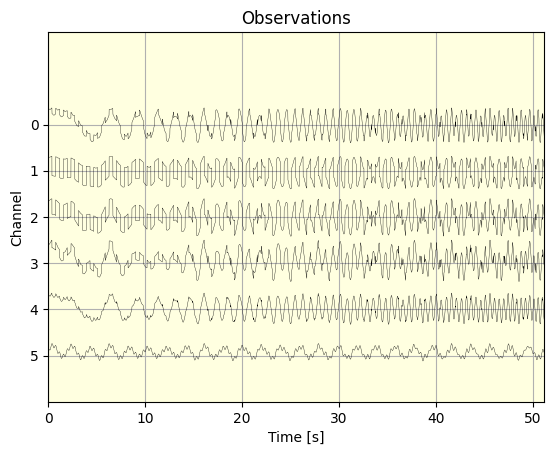

In [ ]:
plot_signal_channels(times=observed_times,
                     signal_channels=observed_signals,
                     channel_names=[str(i) for i in range(observation_number)],
                     amplitude=np.max(np.abs(observed_signals)),
                     title='Observations')

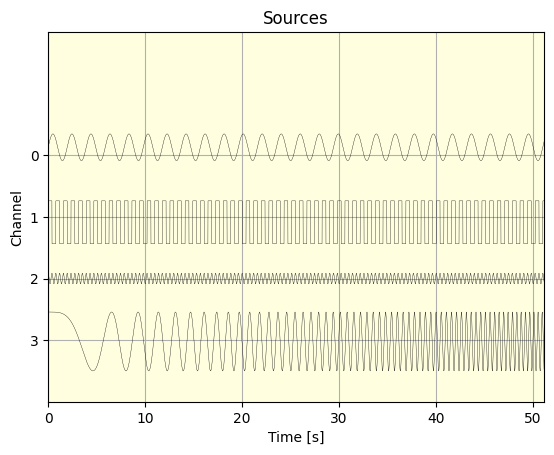

In [ ]:
plot_signal_channels(times=observed_times,
                     signal_channels=source_signals,
                     channel_names=[str(i) for i in range(source_number)],
                     amplitude=np.max(np.abs(source_signals)),
                     title='Sources')

We need to implement the pre-processing pipeline for ICA. At first, we need to ensure that the observed channels have a null mean.

In [ ]:
def center(channels: np.ndarray):

  channel_means = np.mean(channels, axis=1, keepdims=True)

  channels -= channel_means

  return channels, channel_means

Then, we project the observed channels into a new space to ensure that the channels are uncorrelated.

In [ ]:
def decorrelate(channels: np.ndarray, channel_means: np.ndarray):

  centered_channels = channels - channel_means

  cov = centered_channels.dot(centered_channels.T) / np.shape(channels)[1]

  eigenvalues, eigenvectors = np.linalg.eig(cov)

  return eigenvectors.T.dot(centered_channels), eigenvalues, eigenvectors

Finally, we need a function to scale the result according to the eigenvalues.

In [ ]:
def scale(channels: np.ndarray, eigenvalues: np.ndarray):

  return np.dot(np.diag(np.power(eigenvalues + 1e-8, -1/2)), channels)

We define a unique method to carry out the above steps.

In [ ]:
def preprocess(observations: np.ndarray):

  observations, observation_means = center(observations)

  observations, eigenvalues, eigenvectors = decorrelate(observations, observation_means)

  return scale(observations, eigenvalues)

We apply this pre-processing pipeline to the synthetic data we generated.

In [ ]:
whitened_signals = preprocess(observed_signals)

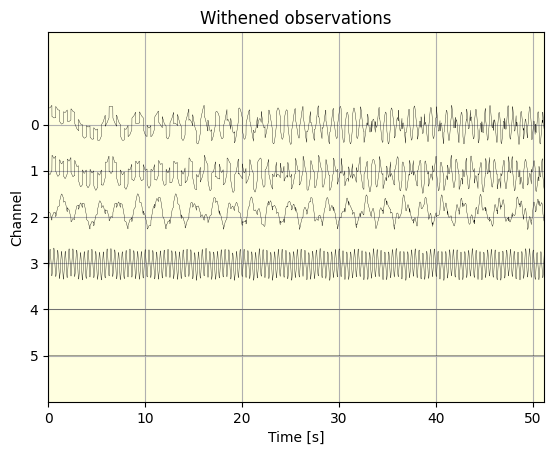

In [ ]:
plot_signal_channels(times=observed_times,
                     signal_channels=whitened_signals,
                     channel_names=[str(i) for i in range(observation_number)],
                     amplitude=np.max(np.abs(whitened_signals)),
                     title='Withened observations')

We can already perceive the signal sources, but decorrelation is not enough to ensure independence! To obtain a better estimate of the signal sources, we implement the FastICA algorithm.

In [ ]:
def fast_ica(whitened_signals: np.ndarray, source_number: int, convergence_threshold=1e-8, max_iteration=1000):

    original_observation_number, sample_number = whitened_signals.shape

    variances = np.var(whitened_signals, axis=1)
    whitened_signals = whitened_signals[variances > 1e-8]

    observation_number, sample_number = whitened_signals.shape

    # Initialize random weights

    W = np.random.rand(source_number, observation_number)

    for source_index in range(source_number):

        w = W[source_index, :].copy().reshape((-1, 1))

        w = w / np.sqrt((w ** 2).sum())

        iteration_index = 0
        convergence_value = 100

        while ((convergence_value > convergence_threshold) & (iteration_index < max_iteration)):

            # Dot product of weight and whitened signal
            ws = np.dot(w.T, whitened_signals)

            # Pass w*s into the first derivative of G
            g1 = np.tanh(ws)

            # Pass w*s into the second derivative of G
            g2 = 1 / (np.cosh(ws) ** 2)

            # Update weights
            new_w = w * np.sum(g2) / sample_number - (np.dot(whitened_signals, g1.T)) / sample_number

            # Decorrelate weights
            for prev_source_index in range(source_index):

              prev_w = W[prev_source_index, :].copy().reshape((-1, 1))

              new_w -= prev_w * np.dot(new_w.T, prev_w)

            #  Normalize
            new_w = new_w / np.sqrt((new_w ** 2).sum())

            # Calculate limit condition
            convergence_value = np.abs(np.abs(np.dot(new_w.T, w)) - 1).item()

            # Update weights
            w = new_w

            # Update counter
            iteration_index += 1

        W[source_index, :] = w.T

    if original_observation_number != observation_number:

        zero_col = np.zeros((source_number, original_observation_number  - observation_number))
        W = np.hstack((W, zero_col))

    return W

We exploit FastICA to estimate the demixing matrix associated with the synthetic signals.

In [ ]:
W = fast_ica(whitened_signals, source_number, convergence_threshold=1e-8, max_iteration=1000)
estimated_source_signals = np.dot(W, whitened_signals)

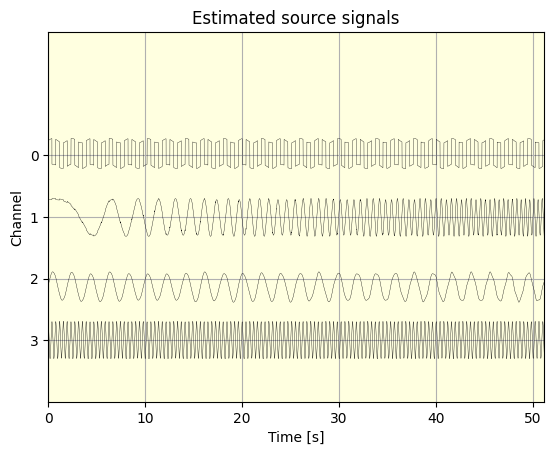

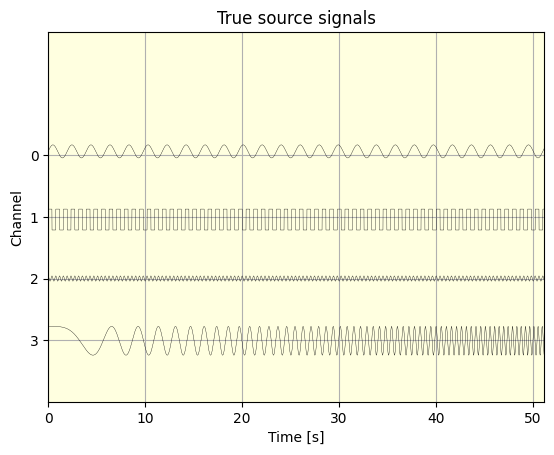

In [ ]:
plot_signal_channels(times=observed_times,
                     signal_channels=estimated_source_signals,
                     channel_names=[str(i) for i in range(source_number)],
                     amplitude=np.max(np.abs(whitened_signals)),
                     title='Estimated source signals')

plot_signal_channels(times=observed_times,
                     signal_channels=source_signals,
                     channel_names=[str(i) for i in range(source_number)],
                     amplitude=np.max(np.abs(whitened_signals)),
                     title='True source signals')

**INDIPENDENT COMPONENT ANALYSIS (ICA) ON EEG DATA**

We can try to apply the same framework to the EEG data, assuming to know the right number of signal sources.

In [ ]:
source_channel_number = 3
observed_channel_number = len(observed_channels)

As before, we apply the pre-processing pipeline to have whitened signals.

In [ ]:
whitened_channels = preprocess(observed_channels)

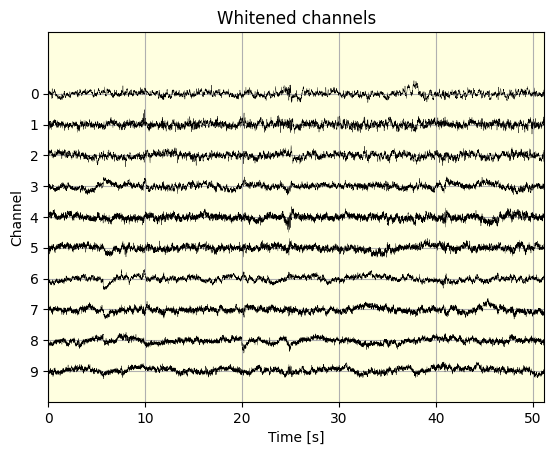

In [ ]:
plot_signal_channels(times=observed_times,
                     signal_channels=whitened_channels,
                     channel_names=[str(i) for i in range(observed_channel_number)],
                     amplitude=np.max(np.abs(whitened_channels)),
                     title='Whitened channels')

We implement the FastICA algorithm to estimate the sources of the EEG signal.

In [ ]:
W = fast_ica(whitened_channels, source_channel_number, convergence_threshold=1e-10, max_iteration=500)
estimated_source_channels = np.dot(W, whitened_channels)

In [ ]:
plot_signal_channels(times=observed_times,
                     signal_channels=estimated_source_channels,
                     channel_names=[str(i) for i in range(source_channel_number)],
                     amplitude=np.max(np.abs(estimated_source_channels)),
                     title='Estimated source channels')

**YOUR TURN**

We have seen how to implement the fastICA algorithm to reconstruct the source signals, both in the case of synthetic and real data. On the other hand, it is hard to tell if the proposed approach works well or not from a quantitative point of view.

From a practical perspective, you can associate performance with the normalized mutual information and check if the fastICA algorithm successfully reduces the amount of information shared between the different signal components. This may give an indication of the optimal number of sources for a given scenario. To compute the mutual information for a given multi-dimensional signal, you can modify the following method.

In [ ]:
def get_normalized_mi(signals: np.ndarray):

    # We consider the Sturges rule to compute the number of bin

    bin_number = ...

    # We consider the sum of the entropy of each single signal

    entropy_sum = 0

    for i in range(signals.shape[0]):

        entropy_sum += ...

    # We consider the joint entropy between all the signals

    joint_entropy = ...

    # We need to find a way normalize the mutual information to deal with scenarios with different number of signals

    normalization_factor = ...

    # We compute the normalized mutual information

    return (entropy_sum - joint_entropy) / normalization_factor

You can then exploit the method to obtain the normalized mutual information associated with both the observations and the source estimations.

In [ ]:
mi_before = get_normalized_mi(observed_channels)
mi_after = get_normalized_mi(estimated_source_channels)

print(f'Normalized mutual information before ICA: {mi_before:.3f}')
print(f'Normalized mutual information after ICA: {mi_after:.3f}')

**HOW TO COMPLETE THE LAB**

To complete the laboratory, to first need to complete the method for computing the normalized mutual information, and then build an ad hoc pipeline to compute the optimal number of sources associated with a given EEG signal. To find the optimal source number, you may try all the possible values (up to the number of observations) and see what minimizes the normalized mutual information. Another option is to modify the pre-processing pipeline and consider only the whitened signals that ensure to maintain 95% of the **cumulative explained variance** (given by the PCA).


In the following, you are asked to implement the ICA pipeline (and your method to determine the optimal number of sources) to all the signals in the laboratory folder, considering **ALL** the patients and not only the one considered as a reference. Hence, for each signal, you have to assess the **performance of the FastICA algorithm** by computing the **normalized mutual information** associated with the **optimal number of signal sources**.

The results of the laboratory, including the mutual information and the optimal source number associated with each EEG signal, must be included in a report. In the report, you must describe the algorithm you implemented to estimate the optimal number of sources and discuss the limits and benefits of the proposed approach. You can also analyze an example of how your code operates over one of the EEG signals in the folder, reporting the signal before and after the ICA implementation.